# Fixed-Step integration of chaotic systems

<!-- [Click here to open this notebook in Colab](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/lorenz_odeint.ipynb) -->
Open this notebook in Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/lorenz_odeint.ipynb)   


We start by importing the necessary Python packages.



<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

In [27]:
# Linear algebra libraries
import numpy as np

# Local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# Numerical integration

Numerical integration seeks to estimate the solution of differential equations of the form

$$\frac{d\mathbf{y}}{dt} = \mathbf{f}(t, \mathbf{y})$$

where $\mathbf{y} \in \mathbb{R}^N$ is a vector of $N$ unknown variables describing the state of the system at time $t$.  We will typically discretize time, so that the solution is a sequence of vectors $\mathbf{y}_0, \mathbf{y}_1, \mathbf{y}_2, \ldots$ describing the solution at discrete times $t_0, t_1, t_2, \ldots$.

### The relationship between integration and optimization

Every optimization problem can be written as an ordinary differential equation (ODE) describing the potential flow $\dot{\mathbf{y}} =  \mathbf{f}(t, \mathbf{y}) = -\nabla U(\mathbf{y}, t)$. However, not every ODE can be written as an optimization problem. Phenomena like limit cycles, chaos, and other interesting phenomena are unique to certain classes of ODEs, but will not occur in optimization problems in standard settings, because potential flows have zero curl.

While we cannot always define a potential function for a given set of ODEs, the gradient and the Hessian are still well-defined. In an ODE context, the gradient is just the right-hand side of the ODE, $\frac{d\mathbf{y}}{dt}$, and the Hessian corresponds to the **Jacobian matrix** of the right-hand side, defined as the matrix of partial derivatives of the right-hand side of the ODE with respect to the unknown variables.

$$
\mathbb{J} = \frac{\partial \dot{\mathbf{y}}}{\partial \mathbf{y}} = \frac{\partial \mathbf{f}}{\partial \mathbf{y}} \in \mathbb{R}^{N \times N}
$$

Writing out this Jacobian matrix,
$$
\mathbb{J} = \begin{bmatrix}
\frac{\partial f_1}{\partial y_1} & \frac{\partial f_1}{\partial y_2} & \cdots & \frac{\partial f_1}{\partial y_n} \\
\frac{\partial f_2}{\partial y_1} & \frac{\partial f_2}{\partial y_2} & \cdots & \frac{\partial f_2}{\partial y_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial f_n}{\partial y_1} & \frac{\partial f_n}{\partial y_2} & \cdots & \frac{\partial f_n}{\partial y_n}
\end{bmatrix}
$$

Just as we saw in optimization, stepping the right-hand side is always necessary to find the next step in the solution. Knowledge of the Jacobian can improve convergence and stability, as well as reveal mathemtical properties of the ODE solution.

<!-- $$
\frac{d\mathbf{y}}{dt} = \mathbb{J} \mathbf{y} -->

# The Thomas Model

To demonstrate our numerical integration scheme, we will use a well-known set of coupled ordinary differential equations, the *Thomas model*, given by
$$
\dot{x} = \sin(y) - b x     \\
\dot{y} = \sin(z) - b y     \\
\dot{z} = \sin(x) - b z     \\
$$
These equations describe the motion of a particle confined in a 3D harmonic potential, subject to a periodic lattice of dispersive forces.

We will frame the problem as an *initial value problem*, where we are given an initial condition $\mathbf{x}(0)$ and asked to find $\mathbf{x}(t)$ for some $t > 0$. 

In [9]:
class ThomasModel:

    def __init__(self, b=0.185):
        self.b = b

    # notice this special method name
    def __call__(self, t, X):
        return self.rhs(t, X)

    def rhs(self, t, X):
        x, y, z = X
        xdot = np.sin(y) - self.b * x
        ydot = np.sin(z) - self.b * y
        zdot = np.sin(x) - self.b * z
        return np.array([xdot, ydot, zdot])

There are few details of our class implementation that we highlight. First, the Thomas equations are implemented as a class, and we set the parameter $b$ is set as an attribute of the class. Since $b$ is a physical property of the system, it will get set when we first instantiate the class.

The logic of the differential equations themselves are implemented in the `rhs` method, which takes in a time $t$ and a state vector $\mathbf{X}$ and returns the right-hand side of the ODE, corresponding to the time derivative of the state vector.

Notice that we also implement a special method name `__call__`. This is a special method name in Python, and it allows us to use the class as if it were a function, the same way that we would use a function in other programming languages.

While we've set up the Thomas model as a class, we haven't yet specified how we want to solve the ODE find the solution to the initial value problem. For now, we'll cheat and use a built-in solver `scipy.integrate.solve_ivp`. This solver accepts a callable function that returns the right-hand side of an ODE, an initial condition, and a time range, and implements a variety of internal integration methods under a unified API. By default, it uses a Runge-Kutta method, but we can specify a different method if we want. *Note: Some Python users might be more familier `scipy.integrate.odeint` instead of `scipy.integrate.solve_ivp`. The latter is a more recent and general suite of solvers*

(np.float64(-4.575815104646805),
 np.float64(4.577407306751987),
 np.float64(-4.574487627901447),
 np.float64(4.5702694417497645))

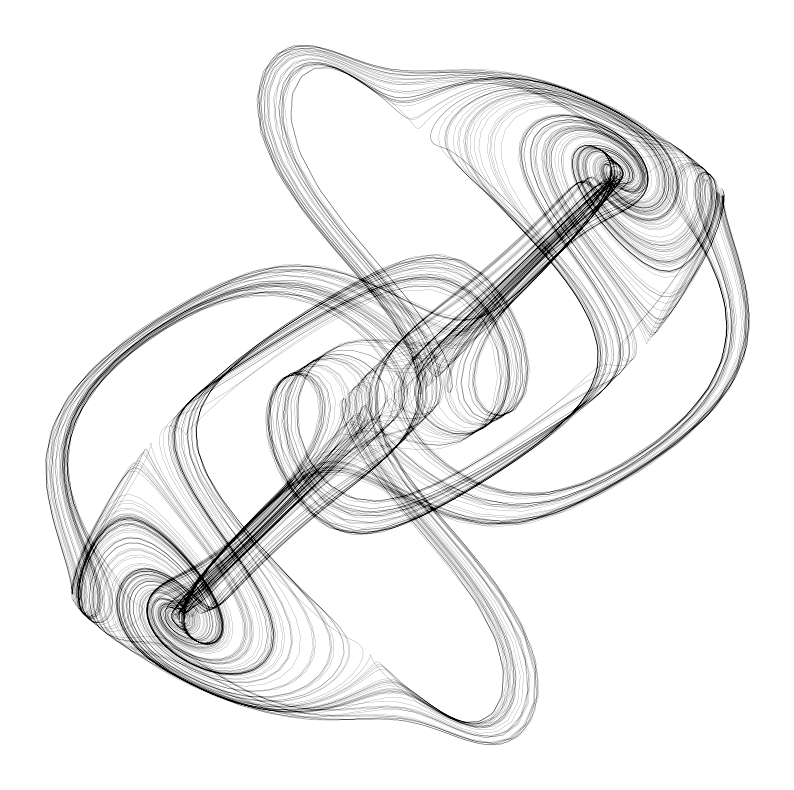

In [6]:
thomas_model = ThomasModel()

# Import the built-in solver scipy.integrate.solve_ivp
from scipy.integrate import solve_ivp
ic = [0.21, 0.3, 0.4]
t = np.linspace(0, 6000, 17000)
sol = solve_ivp(thomas_model, [t[0], t[-1]], ic, t_eval=t)
X = sol.y.T


plt.figure(figsize=(10, 10))
plt.plot(X[:, 0], X[:, 1], linewidth=0.1, color='k', alpha=1.0)
plt.axis('off')

(np.float64(-4.5551990862981935),
 np.float64(4.564902618405367),
 np.float64(-4.561749452508924),
 np.float64(4.560615030434169))

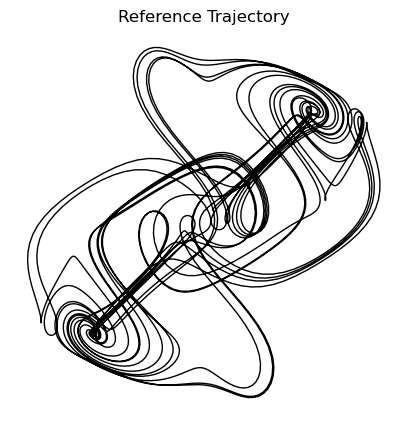

In [7]:
# Let's create an expensive reference trajectory using solve_ivp
from scipy.integrate import solve_ivp
ic = [0.21, 0.3, 0.4]
t = np.linspace(0, 600, 3000)
sol = solve_ivp(thomas_model, [t[0], t[-1]], ic, t_eval=t, method="Radau", max_step=0.005, rtol=1e-8,  atol=1e-16)
X_reference = sol.y.T.copy()
t_reference = sol.t.copy()


plt.figure(figsize=(5, 5))
plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=1, color='k')
plt.title("Reference Trajectory")
plt.axis('off')

## Chaotic systems

Notice that the dynamics of the Thomas model produce a complex, geometric object. This contrasts with other systems we often encounter in physics, which tend, over long timescales, to converge to a fixed point or periodic oscillations. The Thomas model is an example of a *chaotic system*, and the strange attractor it produces is a fractal.

One of the earliest well-studied examples of a chaotic system is the Lorenz model, which is given by the following system of differential equations:

$$
\begin{align}
\dot{x} &= \sigma (y - x) \\
\dot{y} &= x (\rho - z) - y \\
\dot{z} &= x y - \beta z
\end{align}
$$

We can implement this model as a class, just as we did for the Thomas model.

(np.float64(-20.902256501629225),
 np.float64(21.471064289785556),
 np.float64(-28.61074427154573),
 np.float64(29.939403081845946))

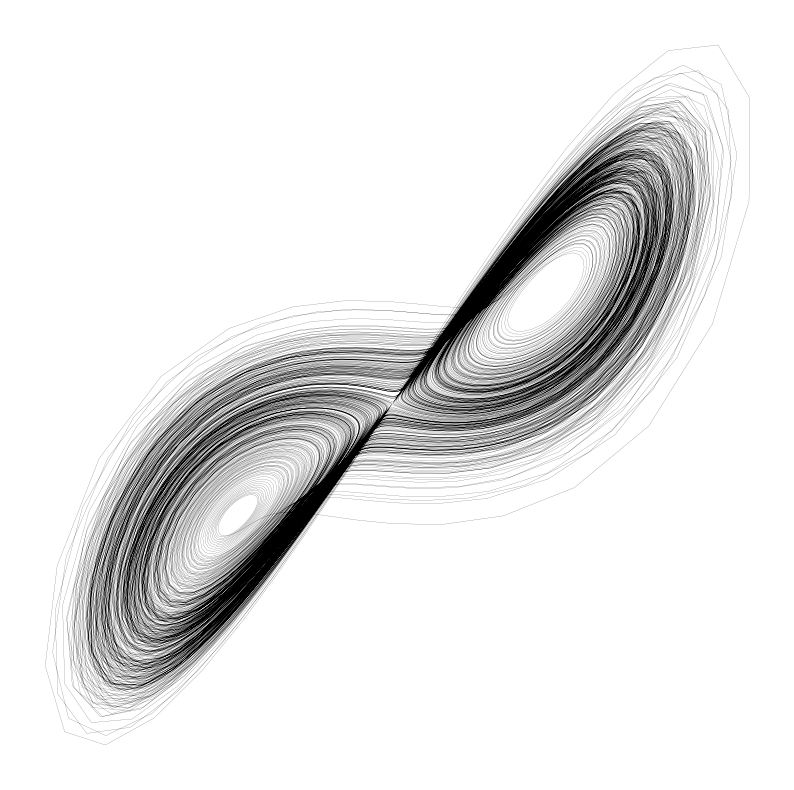

In [16]:
class LorenzModel:

    def __init__(self, sigma=10, rho=28, beta=8/3):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def __call__(self, t, X):
        return self.rhs(t, X)

    def rhs(self, t, X):
        """
        Lorenz dynamical model
        """
        x, y, z = X
        xdot = self.sigma * (y - x)
        ydot = x * (self.rho - z) - y
        zdot = x * y - self.beta * z
        return np.array([xdot, ydot, zdot])

lorenz_model = LorenzModel()

# Let's cheat and integrate the ODE using scipy.integrate.solve_ivp
from scipy.integrate import solve_ivp
ic = [0.21, 0.3, 0.4]
t = np.linspace(0, 500, 20000)
sol = solve_ivp(lorenz_model, [t[0], t[-1]], ic, t_eval=t)
X = sol.y.T


plt.figure(figsize=(10, 10))
plt.plot(X[:, 0], X[:, 1], linewidth=0.1, color='k', alpha=1.0)
plt.axis('off')

## Explicit fixed-step integrators

Explicit fixed-step integrators convert continuous-time dynamical systems to discrete-time maps, corresponding to snapshots of the dynamics every $\Delta t$ timesteps.

The Euler method is the simplest explicit fixed-step integrator. It is a first-order method, and is unconditionally stable for a sufficiently small step size. It is also the most computationally efficient method per evaluation, but it is also the least accurate.

$$
    \mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_n, \mathbf{x}_n)
$$

A common class of higher-order fixed-step integrators are Runge-Kutta methods. These are more computationally expensive than the Euler method, but they are also more accurate.









### There are many other methods that generalize this workflow:

In [17]:
class BaseFixedStepIntegrator:
    """
    A base class for fixed-step integration methods.
    """
    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__
        
    def integrate(self, f, tspan, y0, t_eval=None):
        """
        Integrate the ODE y' = f(t, y) from t0 to tf using an integrator's update method
        """
        t0, tf = tspan

        # Create an array of time points to evaluate the solution
        if t_eval is None:
            t_eval = np.arange(t0, tf, self.dt)

        # Create an array to store the solution (pre-allocate)
        y = np.zeros((len(t_eval), len(y0)))

        # Set the initial condition
        y[0] = y0

        # Integrate the ODE
        for i in range(1, len(t_eval)):
            t = t_eval[i - 1]
            y[i] = self.update(f, t, y[i - 1]) # this will be defined in the subclass

        self.t, self.y = t_eval, np.array(y)
        return self

    def update(self, f, t, y):
        """
        Update the solution using the integrator's method
        """
        raise NotImplementedError("This method must be implemented in a subclass")
        



class Euler(BaseFixedStepIntegrator):
    """
    Note:
    super() calls the constructor of BaseIntegrator
    kwargs collects any passed keyword arguments and passes them on to the constructor 
    of BaseIntegrator
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        return y + self.dt * f(t, y)

(-4.565603884591137, 4.571356431218626, -4.561749452508924, 4.560615030434169)

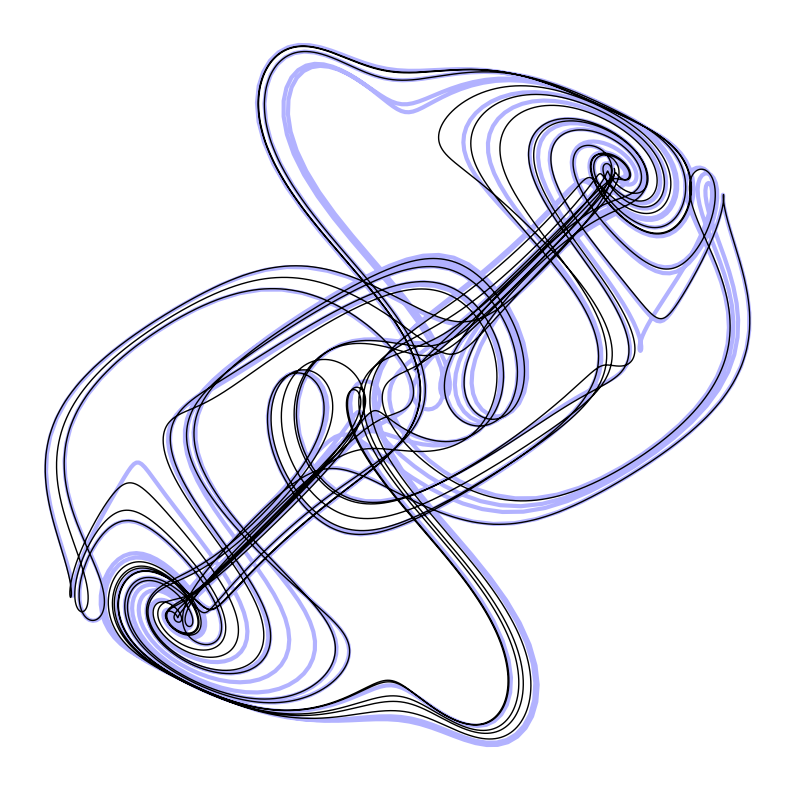

In [168]:
integrator = Euler(dt=0.0001)

ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
sol = integrator.integrate(thomas_model, [t[0], t[-1]], ic)

plt.figure(figsize=(10, 10))
plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=3, color='b', alpha=0.3)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color='k')
plt.axis('off')

### Consider: 

1. How does the Euler method fail at large step sizes
2. What if we try another dynamical system? What kinds of things happen?

# Runge-Kutta Methods

+ Runge-Kutta methods require more evaluations of the right hand side function $\mathbf{f}$ to compute each timestep, but have greater stability and accuracy in exchange
+ An entire family of methods, parametrized by the number of evaluations of $\mathbf{f}$, the points at which these evaluations are made, and the weights used to combine the evaluations.

### The Modifed Euler method

+ The Modified Euler method is more computationally expensive than the Euler method, but it is also more accurate.

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}\left(t_n + \frac{\Delta t}{2},\; \mathbf{x}_n + \frac{\Delta t}{2} \mathbf{f}(t_n, \mathbf{x}_n)\right)
$$


In [22]:

class ModifiedEuler(BaseFixedStepIntegrator):
    """
    The modified Euler method is a second-order method, so it is more accurate than the 
    Euler method.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        # y + self.dt * f(t, y)
        k1 = f(t, y)
        k2 = f(t + self.dt / 2, y + self.dt * k1 / 2)
        return y + self.dt * k2

(-4.572806513204148, 4.5686973469229955, -4.565144416271675, 4.572411835432394)

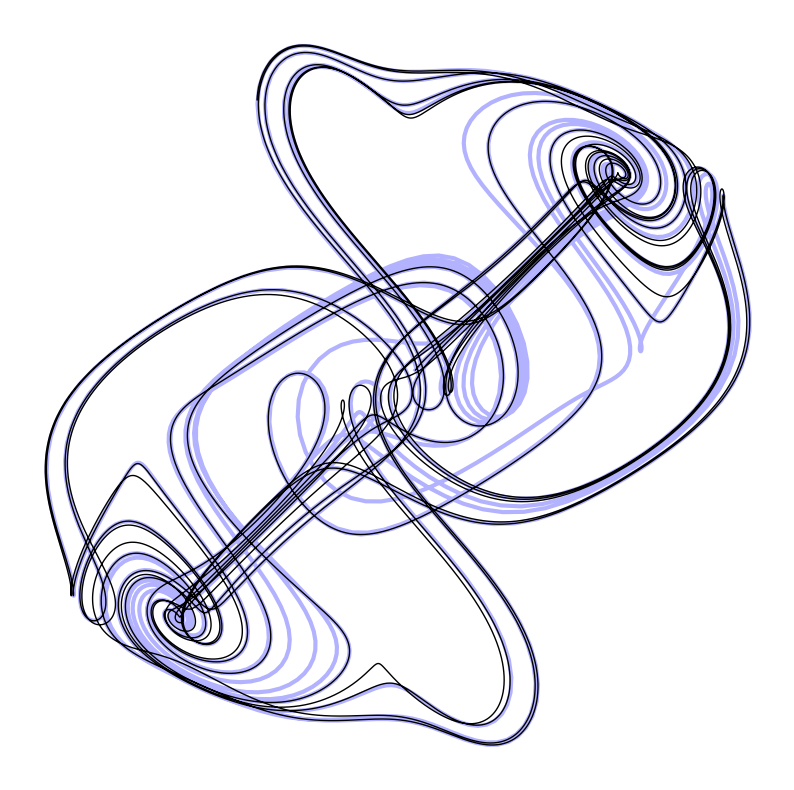

In [171]:
integrator = ModifiedEuler(dt=0.001)

ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
sol = integrator.integrate(thomas_model, [t[0], t[-1]], ic)

plt.figure(figsize=(10, 10))
plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=3, color='b', alpha=0.3)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color='k')
plt.axis('off')

We can re-write the modified Euler method,

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}\left(t_n + \frac{\Delta t}{2},\; \mathbf{x}_n + \frac{\Delta t}{2} \mathbf{f}(t_n, \mathbf{x}_n)\right)
$$

As a series of intermediate evaluations,

$$
k_1 = \mathbf{f}(t_n, \mathbf{x}_n)
$$
$$
k_2 = \mathbf{f}(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2}k_1 )
$$
$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; k_2
$$

Notice how each step depends on intermediate calculations performed in the previous steps

There are many other methods that generalize this workflow:

**Heun's method (RK2(3))** corresponds to a forward/explicit variant of the trapezoidal rule

$$
\tilde{\mathbf{x}}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_n, \mathbf{x}_n) \\
$$
$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \frac{1}{2}\left(\mathbf{f}(t_n, \mathbf{x}_n) + \mathbf{f}(t_{n+1}, \tilde{\mathbf{x}}_{n+1})\right)
$$

In [18]:
class Heun(BaseFixedStepIntegrator):
    """
    The Heun method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt, y + self.dt * k1)
        return y + self.dt * (k1 + k2) / 2

**Ralston's method (RK3(4))** is a third-order method that is more accurate than Heun's method

$$
\begin{align}
k_1 &= \mathbf{f}(t_n, \mathbf{x}_n) \\
k_2 &= \mathbf{f}\left(t_n + \frac{\Delta t}{4}, \mathbf{x}_n + \frac{\Delta t}{4} k_1\right) \\
k_3 &= \mathbf{f}\left(t_n + \frac{3\Delta t}{4}, \mathbf{x}_n + \frac{3\Delta t}{4} k_2\right) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{\Delta t}{9}\left(2 k_1 + 3 k_2 + 4 k_3\right)
\end{align}
$$

In [19]:
class Ralston(BaseFixedStepIntegrator):
    """
    The Ralston method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt / 2, y + self.dt * k1 / 2)
        return y + self.dt * k2






**Fourth-order Runge-Kutta or RK4(5)** is the default solver in many older languages (though Dormand-Prince, an adaptive step-size method, is more common in modern languages).

$$
\begin{align}
k_1 &= \mathbf{f}(t_n, \mathbf{x}_n) \\
k_2 &= \mathbf{f}\left(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2} k_1\right) \\
k_3 &= \mathbf{f}\left(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2} k_2\right) \\
k_4 &= \mathbf{f}\left(t_n + \Delta t, \mathbf{x}_n + \Delta t k_3\right) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{\Delta t}{6}\left(k_1 + 2 k_2 + 2 k_3 + k_4\right)
\end{align}
$$



In [20]:

class RK4(BaseFixedStepIntegrator):
    """
    The Runge-Kutta 4 method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt / 2, y + self.dt * k1 / 2)
        k3 = f(t + self.dt / 2, y + self.dt * k2 / 2)
        k4 = f(t + self.dt, y + self.dt * k3)
        return y + self.dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6



We can take this idea even futher, defining Runge-Kutta methods of arbitrary order.

In [24]:

class RK7(BaseFixedStepIntegrator):
    """
    The Runge-Kutta 10 method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt / 5, y + self.dt * k1 / 5)
        k3 = f(t + self.dt * 3 / 10, y + self.dt * (3 * k1 / 40 + 9 * k2 / 40))
        k4 = f(t + self.dt * 4 / 5, y + self.dt * (44 * k1 / 45 - 56 * k2 / 15 + 32 * k3 / 9))
        k5 = f(t + self.dt * 8 / 9, y + self.dt * (19372 * k1 / 6561 - 25360 * k2 / 2187 + 64448 * k3 / 6561 - 212 * k4 / 729))
        k6 = f(t + self.dt, y + self.dt * (9017 * k1 / 3168 - 355 * k2 / 33 + 46732 * k3 / 5247 + 49 * k4 / 176 - 5103 * k5 / 18656))
        k7 = f(t + self.dt, y + self.dt * (35 * k1 / 384 + 500 * k3 / 1113 + 125 * k4 / 192 - 2187 * k5 / 6784 + 11 * k6 / 84))
        return y + self.dt * (35 * k1 / 384 + 500 * k3 / 1113 + 125 * k4 / 192 - 2187 * k5 / 6784 + 11 * k6 / 84)

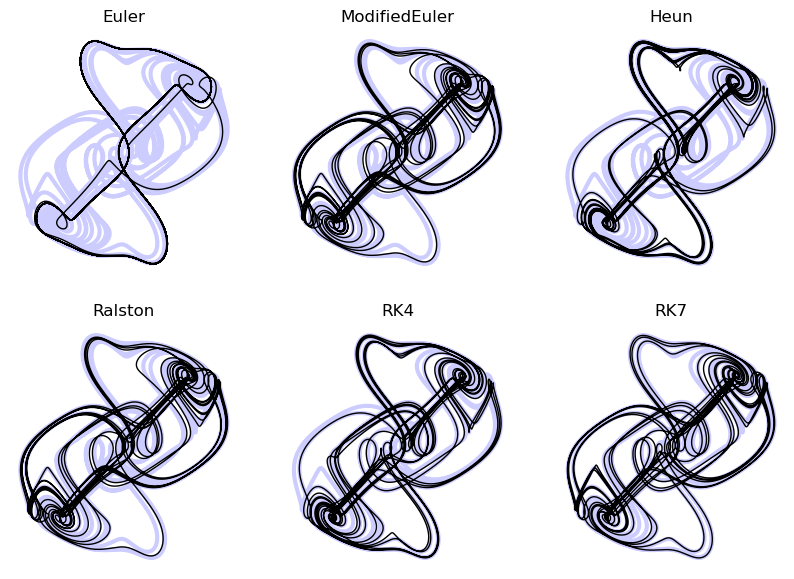

In [25]:
# dt_val = 0.5
dt_val = 0.1
system = thomas_model 
# system = lorenz_model
ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)

plt.figure(figsize=(10, 7))

for i, integrator in enumerate([Euler(), ModifiedEuler(), Heun(), Ralston(), RK4(), RK7()]):
    integrator.dt = dt_val
    sol = integrator.integrate(system, [t[0], t[-1]], ic)

    plt.subplot(2, 3, i+1)
    plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=3, color='b', alpha=0.2)
    plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color="k")
    plt.title(integrator.name)
    plt.axis('off')


## Butcher Tableau

A recursive set of definitions for the coefficients in explicit Runge-Kutta methods

#### Generic Runge-Kutta methods

$$
k_{ni} = \mathbf{f}\left(t_n + c_i \Delta t,\;\; \mathbf{x}_n + \Delta t \sum_{j=1}^s a_{ij} k_{nj}\right)
$$

The Butcher tableau is a table that summarizes the coefficients of the method

$$
\begin{array} {c|ccccc} 0\\ c_2 & a_{21}\\ c_3 & a_{31} & a_{32} \\ \vdots & \vdots & & \ddots \\ c_s& a_{s1}& a_{s2} & \cdots & a_{s,s-1}\\ \hline & b_1 & b_2 & \cdots & b_{s-1} & b_s \end{array}
$$

We read the Butcher Tableau from bottom to top, starting with the final step, and then going up the table to see how each step is constructed from the previous steps. However, computationally, we traverse the table from top to bottom. The all-zero row always corresponds to the forward Euler step, which serves as a base case for the recursion

Each column tells us how much to weight the output of the corresponding previous row when computing that row.


#### Euler's method (forward step)

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_n, \mathbf{x}_n)
$$

\begin{array} 
{c|c} 0 & 0\\ \hline & 1
\end{array}

<!-- #### Euler's method (backward step)

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

\begin{array} 
{c|c} 1 & 1\\ \hline & 1
\end{array} -->

#### Modified Euler's method

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}\left(t_n + \frac{\Delta t}{2},\; \mathbf{x}_n + \frac{\Delta t}{2} \mathbf{f}(t_n, \mathbf{x}_n)\right)
$$

\begin{array}
{c|cc} 0 & 0 & 0\\ \frac{1}{2} & \frac{1}{2} & 0\\ \hline & 0 & 1
\end{array}


#### Heun's method

$$
\tilde{\mathbf{x}}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_n, \mathbf{x}_n) \\
$$
$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \frac{1}{2}\left(\mathbf{f}(t_n, \mathbf{x}_n) + \mathbf{f}(t_{n+1}, \tilde{\mathbf{x}}_{n+1})\right)
$$

\begin{array}
    {c|cc} 0 & 0 & 0\\ 1 & 1 & 0\\ \hline & 1/2 & 1/2
\end{array}

#### Ralston's method


$$
\begin{align}
k_1 &= \mathbf{f}(t_n, \mathbf{x}_n) \\
k_2 &= \mathbf{f}\left(t_n + \frac{\Delta t}{4}, \mathbf{x}_n + \frac{\Delta t}{4} k_1\right) \\
k_3 &= \mathbf{f}\left(t_n + \frac{3\Delta t}{4}, \mathbf{x}_n + \frac{3\Delta t}{4} k_2\right) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{\Delta t}{9}\left(2 k_1 + 3 k_2 + 4 k_3\right)
\end{align}
$$

\begin{array}
{c|ccc} 0 & 0 & 0 & 0\\ 1/4 & 1/4 & 0 & 0\\ 3/4 & 0 & 3/4 & 0\\ \hline & 2/9 & 3/9 & 4/9
\end{array}

#### Runge-Kutta 4th order (RK4)

This is the most common fixed-step Runge-Kutta method,

$$
    \begin{align}
    k_1 &= \mathbf{f}(t_n, \mathbf{x}_n) \\
    k_2 &= \mathbf{f}\left(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2} k_1\right) \\
    k_3 &= \mathbf{f}\left(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2} k_2\right) \\
    k_4 &= \mathbf{f}\left(t_n + \Delta t, \mathbf{x}_n + \Delta t k_3\right) \\
    \mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{\Delta t}{6}\left(k_1 + 2 k_2 + 2 k_3 + k_4\right)
    \end{align}
$$


\begin{array}
{c|cccc} 0 & 0 & 0 & 0 & 0\\ 1/2 & 1/2 & 0 & 0 & 0\\ 1/2 & 0 & 1/2 & 0 & 0\\ 1 & 0 & 0 & 1 & 0\\ \hline & 1/6 & 1/3 & 1/3 & 1/6
\end{array}

<!-- 
\begin{bmatrix}
0 & 0 & 0 & 0 & 0\\ 
1/2 & 1/2 & 0 & 0 & 0\\ 
1/2 & 0 & 1/2 & 0 & 0\\ 
1 & 0 & 0 & 1 & 0\\ 
\hline & 1/6 & 1/3 & 1/3 & 1/6
\end{bmatrix} -->



<!-- \begin{array} {c|ccccc} c_1 & a_{11} & a_{12} & \cdots & a_{1s} \\ c_2 & a_{21} & a_{22} & \cdots & a_{2s} \\ \vdots & \vdots & & \ddots & \vdots \\ c_s& a_{s1}& a_{s2} & \cdots & a_{s,s}\\ \hline & b_1 & b_2 & \cdots & b_{s} \end{array}


Notes here:
https://www.johndcook.com/blog/2020/02/13/runge-kutta-methods/ -->

### Convergence and stability of ODE solvers: various definitions of error

The *global error* of a solver at a given step is given by
$$
    e_n = || \mathbf{x}_{n} - \mathbf{X}(t_{n})||
$$
where $\mathbf{X}(t_{n})$ is the exact solution at that time step. 

The *truncation error* for a fixed-step solver with step size $\Delta t$ is
$$
    T_n = \frac{\mathbf{x}_{n+1} - \mathbf{x_n}}{\Delta t} - \mathbf{f}(t_n, \mathbf{X}(t_{n}))
$$
Where we've applied the right hand side of the ODE to the *exact* solution to get the exact derivative at that time step. Notice that this quantity is a property of our solver.

The *local error* is therefore given by
$$
    \ell_n = \Delta t \; ||T_n||
$$

This measures the error introduced during a single timestep, under a linear approximation of the ODE.




## Global error accumulates from local error

The global error is given by
$$
e_n = || \mathbf{x}_{n} - \mathbf{X}(t_{n})||
$$
where $\mathbf{X}(t_{n})$ is the exact solution at that time step. The global error at the next step is given by
$$
e_{n+1} = || \mathbf{x}_{n+1} - \mathbf{X}(t_{n+1})||
$$

We can use the Taylor series expansion of the exact solution, and of the numerical solution, to write
$$
\mathbf{X}(t_{n+1}) = \mathbf{X}(t_{n}) + \Delta t \mathbf{X}'(t_{n}) + \frac{\Delta t^2}{2} \mathbf{X}''(t_{n}) + \cdots
$$
$$
\mathbf{x}_{n+1} = \mathbf{x}_{n} + \Delta t \mathbf{f}(t_n, \mathbf{x}_n) + \frac{\Delta t^2}{2} ≈'(t_n, \mathbf{x}_n) + \cdots
$$

where $\mathbf{X}' \equiv \mathbf{f}(\mathbf{X})$. Substituting both expansions into the global error at the next step, we get

$$
e_{n+1} = || \mathbf{x}_{n} + \Delta t \mathbf{f}(t_n, \mathbf{x}_n) + \frac{\Delta t^2}{2} \mathbf{f}'(t_n, \mathbf{x}_n) + \cdots - \mathbf{X}(t_{n}) - \Delta t \mathbf{X}'(t_{n}) - \frac{\Delta t^2}{2} \mathbf{X}''(t_{n}) - \cdots||
$$

Rearranging terms,

$$
e_{n+1} = || \bigg(\mathbf{x}_{n} - \mathbf{X}(t_{n})\bigg) + \Delta t \bigg(\mathbf{f}(t_n, \mathbf{x}_n) - \mathbf{X}'(t_{n})\bigg) + \frac{\Delta t^2}{2} \bigg( \mathbf{f}'(t_n, \mathbf{x}_n) - \mathbf{X}''(t_{n})\bigg) + \cdots ||
$$



Now, let's assume that $\mathbf{f}$ satisfies a Lipshitz condition, which means that the derivative of $\mathbf{f}$ is Lipschitz continuous with respect to the solution. This means that the derivative of $\mathbf{f}$ is bounded by a constant $L$ in terms of the solution. Then we can write

$$
|\mathbf{f}(t, u) - \mathbf{f}(t, v)| \leq L ||u - v|| |
$$

Where $L$ is a constant called the Lipshitz constant. This means that the derivative of $\mathbf{f}$ is bounded by a constant $L$. If we have a simple right hand side, then we can calculate the Lipshitz constant as the maximum of the gradient on the domain of the problem, for all values of $t$. However, even non-differentiable functions can satisfy a Lipshitz condition.

Hence,
$$
|e_{n+1}| \leq |e_{n}| + \Delta t L_f |e_n| + \Delta t |T_k|
$$

$$
|e_{n+1}| \leq |e_{n}| (1 + \Delta t L_f) + \Delta t |T_k|
$$

Where the truncation error term captures the higher-order terms in our grouped series expansion above. This expression therefore relates the rate of growth in the global error $|e_{n}|$ to the Lipschitz constant of our problem $L$, and the properties of our solving method $T$.

Let's recap what we just learned: A problem has an intrinsic difficulty set by the Lipschitz constant $L$, and but we can change $\Delta t$ and $T_k$ to control the global error growth rate. If we need a given $\Delta t$ to to limits on the number of timesteps we can simulate, we can choose the order of the method $T_k$ to control the local error. Likewise, if we need to limit the order of our method due to memory or overhead limits, we can choose a smaller $\Delta t$ to control the global error growth rate. We can thus see that there is an implicit trade-off between accuracy and computational cost.


## Implicit Integration

Recall that the forward Euler method is given by

$$
\mathbf{x}_{n+1} = \mathbf{x}_{n} + \Delta t \mathbf{f}(t_n, \mathbf{x}_n)
$$

Implicit integration method like the "backward" Euler method attempt to solve ODE using iterations of the form

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

Because $\mathbf{x}_{n+1}$ appears on both sides of the equation, we need to solve for it. This is therefore a nonlinear equation in $\mathbf{x}_{n+1}$ that we need to solve *in each step*.


### Relation to Butcher tableau

The forward Euler method had a Butcher tableau of the form

$$
\begin{array}{c|c}
0 & 0 \\
\hline
 & 1
\end{array}
$$

The backward Euler method has a Butcher tableau of the form

$$
\begin{array}{c|c}
1 & 1 \\
\hline
 & 1
\end{array}
$$

Generally speaking, Butcher tableau for implicit methods have non-zero entries above the main diagonal. This implies that the an element in a given row can depend on an element at a later row.


### The Backwards Euler method

The backwards Euler method has the form
$$
    \mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

unlike the forward Euler method, the gradient term depends on the unknown value of the state **at a future timestep**. Isolating this unknown $\mathbf{x}_{n+1}$, we get
$$
    \mathbf{x}_n = \mathbf{x}_{n+1} - \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

We define an auxiliary function $\mathbf{g}$ and auxiliary variable $\mathbf{u} = \mathbf{x}_{n+1}$
$$
    \mathbf{g}(\mathbf{u}) = \mathbf{u} - \mathbf{x}_n - \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{u})
$$

We want to minimize this function in order to determine $\mathbf{x}_{n+1}$. Taking the gradient of $\mathbf{g}$ with respect to $\mathbf{u}$, we get

$$
\frac{\partial \mathbf{g}}{\partial \mathbf{u}} = \mathbf{I} - \Delta t\; \frac{\partial \mathbf{f}}{\partial \mathbf{u}}
$$

Recall that $J(\mathbf{u})$ is the Jacobian of $\mathbf{f}$ evaluated at $\mathbf{u}$.

We can therefore optimize in $\mathbf{u}$ using the Newton's method

$$
\mathbf{u}_{n+1} = \mathbf{u}_n - \left(\mathbf{I} - \Delta t\; J(\mathbf{u})\right)^{-1}\mathbf{g}(\mathbf{u}_n)
$$

After we complete our optimization, we set $\mathbf{x}_{n+1} = \mathbf{u}_{n+1}$ and then move to the next timestep

<!-- We take the gradient with respect to $\mathbf{x}_{n+1}$ to get

$$
\frac{\partial \mathbf{x}_n}{\partial \mathbf{x}_{n+1}} = \mathbf{I} - \Delta t\; J(t_{n+1}, \mathbf{x}_{n+1})
$$

where $\mathbf{I}$ is the identity matrix and $J$ is the Jacobian of $\mathbf{f}$ evaluated at $\mathbf{x}_{n+1}$. We can therefore solve for $\mathbf{x}_{n+1}$ by approximating this solution with the Newton-Raphson method: -->


First, we need to add analytic Jacobians for our differential equations in order to use Newton's method

In [174]:


class ThomasModelWithJacobian(ThomasModel):
        
    def jac(self, t, X):
        x, y, z = X
        J = np.array([
            [-self.b, np.cos(y), 0],
            [0, -self.b, np.cos(z)],
            [np.cos(x), 0, -self.b]
        ])
        return J


class LorenzModelWithJacobian(LorenzModel):

    def jac(self, t, X):
        x, y, z = X
        J = np.array([
            [-self.sigma, self.sigma, 0],
            [self.rho - z, -1, -x],
            [y, x, -self.beta]
        ])
        return J

thomas_model = ThomasModelWithJacobian()
lorenz_model = LorenzModelWithJacobian()

In [135]:
class ImplicitEuler(BaseFixedStepIntegrator):
    """
    The implicit Euler method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def newton(self, f, jac, t, y, tol=1e-6, max_iter=30):
        """
        Newton's method for solving nonlinear equations

        assumes that the rhs is stored in f, and the jacobian is stored in jac

        """
        y0 = y.copy()
        n = len(y)
        for i in range(max_iter):
            g = y - y0 - self.dt * f(t, y)
            dg = np.identity(n) - self.dt * jac(t, y)
            #dy = np.linalg.solve(dg, g) # slightly faster than 
            dy = np.linalg.inv(dg) @ g
            y -= dy
            if np.linalg.norm(dy) < tol:
                break
        return y
    
    def update(self, f, t, y):
        return self.newton(f, f.jac, t, y)


        


0.1
0.1


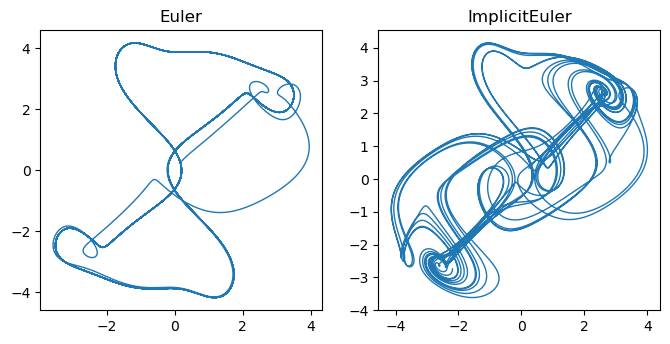

In [175]:
dt_val = 0.1
ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
system = thomas_model


plt.figure(figsize=(8, 8))

# explicit methods
integrator = Euler(dt=dt_val)
sol = integrator.integrate(system, [t[0], t[-1]], ic)
plt.subplot(2, 2, 1)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1)
plt.title(integrator.name)
print(integrator.dt)

# implicit methods
integrator = ImplicitEuler(dt=dt_val)
sol = integrator.integrate(system, [t[0], t[-1]], ic)
plt.subplot(2, 2, 2)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1)
plt.title(integrator.name)
print(integrator.dt)


## Why use implicit methods?

+ Each step is more expensive than the explicit Euler method, but the method is more accurate.
+ Can get away with using a larger time step.
+ Can mathematically do the same thing we just did for Euler for Runge-Kutta and other methods, but the math gets more complicated due to all the recursive definitions.

## Multistep methods

+ "Stiff" equations: $\mathbf{f}$ is very sensitive to small changes in $\mathbf{x}$. 
+ The Lipshitz constant $L$ is large on a non-trivial portion of the solution domain. 
+ Usually have to pick extremely small $\Delta t$ to get a stable solution.
+ Mechanistically, this often results from systems having two very well-separated timescales, both of which need to be resolved. Chaotic systems are often stiff.
+ These approaches are reministicent of "momentum" in optimization, in which we use memory of past updates to inform the current one.

Idea: Combine past steps to get a better estimate of the current step. Common methods are Adams-Bashforth and Adams-Moulton, as well as BDF (backward differentiation formula). The latter is a workhorse method for stiff ODEs that is included in SciPy's `solve_ivp` function.


Our Runge-Kutta methods had the form:

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t \sum_{i=1}^s b_i \mathbf{k}_i
$$
where $\mathbf{k}_i$ are the slopes at the intermediate points. We can generalize this to multistep methods by composing our first step as well.

A linear multistep method has the general form:
$$
\mathbf{x}_{n+1} = \sum _{i=0}^{s} a_{i} \mathbf{x}_{n-i} + \Delta t \sum _{j=-1}^{s}b_{j}\mathbf{f}\left(t_{n-j},\mathbf{x}_{n-j}\right).
$$
where $s$ is the order of the method. For example, the Adams-Bashforth method has coefficients $a_i = 0$ for $i > 0$ and $b_j = 1$ for $j \geq 0$. The second order Adams-Bashforth method is given by

$$
\mathbf{x}_{n+1} = \mathbf{x}_{n} + \Delta t \bigg({\tfrac {3}{2}}\mathbf{f}(t_{n}, \mathbf{x}_{n})-{\tfrac {1}{2}}\mathbf{f}(t_{n-1}, \mathbf{x}_{n-1})\bigg)
$$


In [159]:
class AdamsBashforth:
    """
    The Adams-Bashforth method for integration
    """
    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__
        
    def integrate(self, f, tspan, y):
        """
        Integrate the system using the Adams-Bashforth method

        """
        self.t = np.arange(tspan[0], tspan[-1], self.dt)
        self.y = np.zeros((len(self.t), len(y)))
        self.y[0] = y
        self.y[1] = self.y[0] + self.dt * f(self.t[0], self.y[0])
        for i, t in enumerate(self.t):
            if i < 2:
                continue
            self.y[i] = self.y[i - 1] + self.dt * (3/2 * f(t, self.y[i-1]) - 1/2 * f(t, self.y[i-2]))
        return self

(-4.5623945389624785,
 4.5682038154685385,
 -4.564564347026234,
 4.560749073030232)

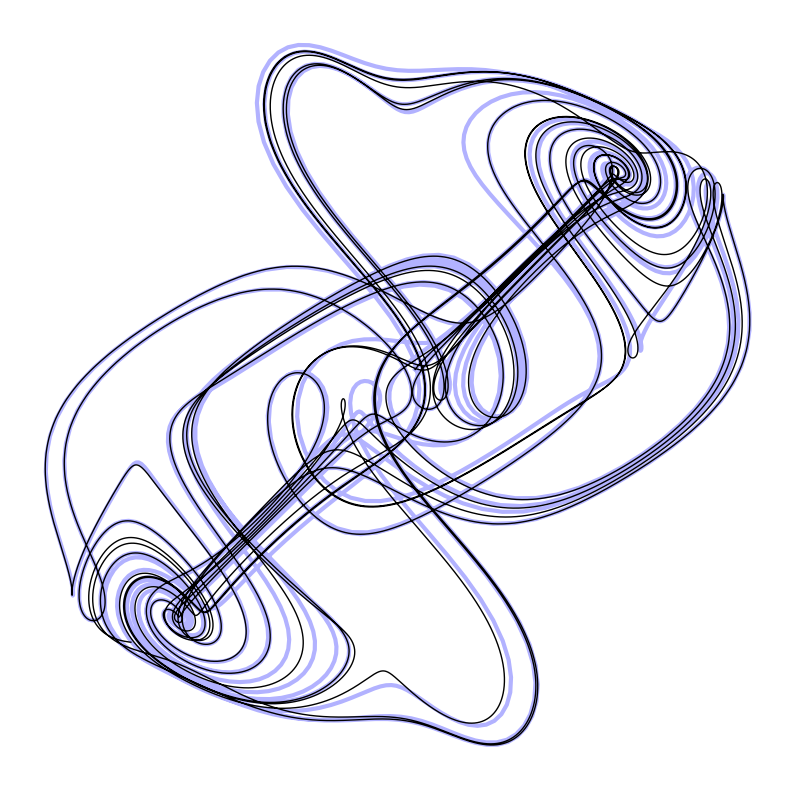

In [161]:
dt_val = 0.001
ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
system = thomas_model


integrator = AdamsBashforth(dt=dt_val)
sol = integrator.integrate(system, [t[0], t[-1]], ic)
# plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1)
# plt.title(integrator.name)
# print(integrator.dt)


plt.figure(figsize=(10, 10))
plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=3, color='b', alpha=0.3)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color='k')
plt.axis('off')

The second-order Adams-Moulton method is given by

$$
\mathbf{x}_{n+1} = \mathbf{x}_{n} + \Delta t \bigg({\tfrac {1}{2}}\mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})+{\tfrac {1}{2}}\mathbf{f}(t_{n}, \mathbf{x}_{n})\bigg)
$$

Notice that this method has an implicit definition. This implicit equation represents the *trapezoidal rule*

## Predictor-Corrector methods

+ Predictor-corrector methods are a generalization of the multistep methods to use future estimated terms, rather than just past terms.
+ The idea is to use a multistep method to predict the next step, and then use a single step method to correct the prediction.
+ The multistep method is called the *predictor*, and the single step method is called the *corrector*.

For example, instead of solving the implicit equation for the Adams-Moulton method, we can use the explicit Euler method to correct the prediction. This is called the *Adams-Bashforth-Moulton* method. The general form is

$$
\tilde{\mathbf{x}}_{n+1} = \mathbf{x}_{n} + \Delta t\; \mathbf{f}(t_{n}, \tilde{\mathbf{x}}_{n})
$$
$$
\mathbf{x}_{n+1} = \mathbf{x}_{n} + \Delta t \bigg({\tfrac {1}{2}}\mathbf{f}(t_{n+1}, \tilde{\mathbf{x}}_{n+1})+{\tfrac {1}{2}}\mathbf{f}(t_{n}, \mathbf{x}_{n})\bigg)
$$



In [162]:
class AMPredictorCorrector:
    """
    The Adams-Moulton method for integration with predictor-corrector updates
    """
    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__
        
    def integrate(self, f, tspan, y):
        """
        Integrate the system using the Adams-Moulton method

        """
        self.t = np.arange(tspan[0], tspan[-1], self.dt)
        self.y = np.zeros((len(self.t), len(y)))
        self.y[0] = y
        for i, t in enumerate(self.t):
            if i < 1:
                continue
            # predictor-corrector
            ytilde = y + self.dt * f(t, y)
            y = y + self.dt * 0.5 * (f(t, y) + f(t, ytilde))
            self.y[i] = y.copy()
        return self

    

(-4.559061621883538, 4.571677473118116, -4.571764220265976, 4.561091924136886)

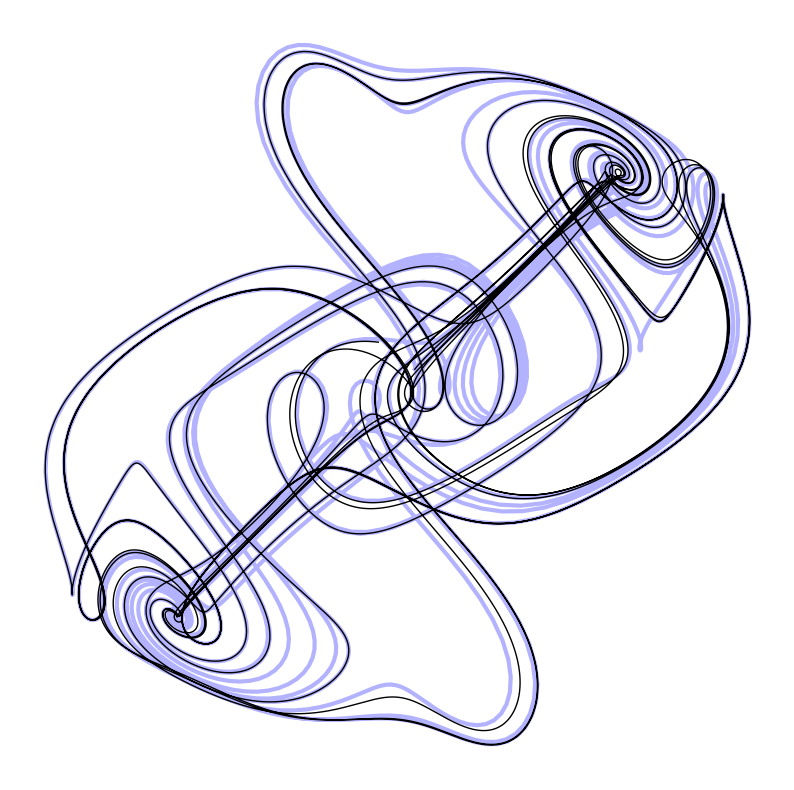

In [164]:
dt_val = 0.001
ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
system = thomas_model


integrator = AMPredictorCorrector(dt=dt_val)
sol = integrator.integrate(system, [t[0], t[-1]], ic)
# plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1)
# plt.title(integrator.name)
# print(integrator.dt)

plt.figure(figsize=(10, 10))
plt.plot(X_reference[:, 0], X_reference[:, 1], linewidth=3, color='b', alpha=0.3)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color='k')
plt.axis('off')

## Let's have a numerical integration bakeoff

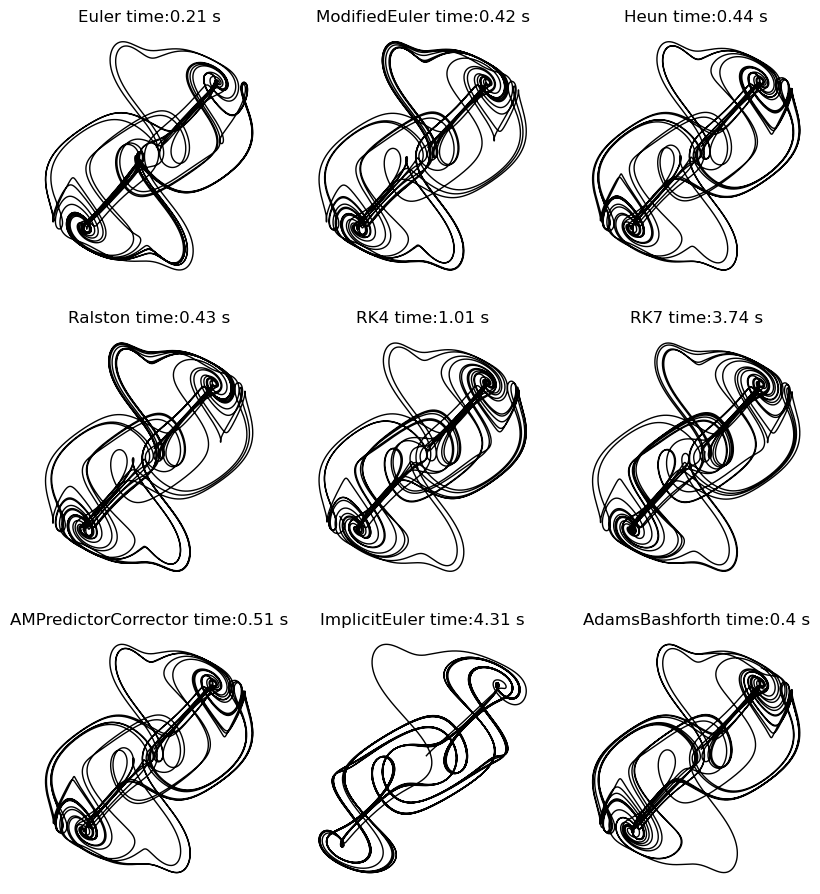

In [180]:
dt_val = 0.01
# dt_val = 0.5
ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
system = thomas_model



## A helpful function for computing the error of a method
def interp1d_axis(x, xp, fp, axis=-1):
    """
    Interpolate an array in one dimension along a specified axis
    
    Args:
        x (list or np.ndarray): 
        xp (list or np.ndarray): 
        xp (list or np.ndarray): 
    
    """

    y_resample = list()
    for i in range(fp.shape[axis]):
        y_resample.append(
            np.interp(x, xp, fp[:, i])
        )
    y_resample = np.array(y_resample).T
    return y_resample

integrators = [
    Euler(),
    ModifiedEuler(),
    Heun(),
    Ralston(),
    RK4(),
    RK7(),
    AMPredictorCorrector(),
    ImplicitEuler(),
    AdamsBashforth(),
]

import time

all_results = dict() # an object to store our bakeoff results
plt.figure(figsize=(10, 15))
for i, integrator in enumerate(integrators):
    integrator.dt = dt_val

    t0 = time.time()
    sol = integrator.integrate(system, [t[0], t[-1]], ic)
    t1 = time.time()
    runtime = t1 - t0


    ## Compute the Mean-squared error compared to the high-fidelity reference trajectory 
    ## we found above. Because we are using a different integration timestep, we 
    ## downsample our solutions to match the reference
    y_resample = interp1d_axis(t_reference, sol.t, sol.y)
    err = np.mean(np.sum((X_reference - y_resample)**2, axis=-1))

    integrator_name = type(integrator).__name__
    all_results[integrator_name] = dict()
    all_results[integrator_name]["time"] = runtime
    all_results[integrator_name]["error"] = err
    
    plt.subplot(4, 3, i + 1)
    plt.plot(sol.y[:, 0], sol.y[:, 1], 'k', linewidth=1)
    plt.title(integrator.name + " time:" + str(round(runtime, 2)) + " s")
    plt.axis("off")

plt.show()



    


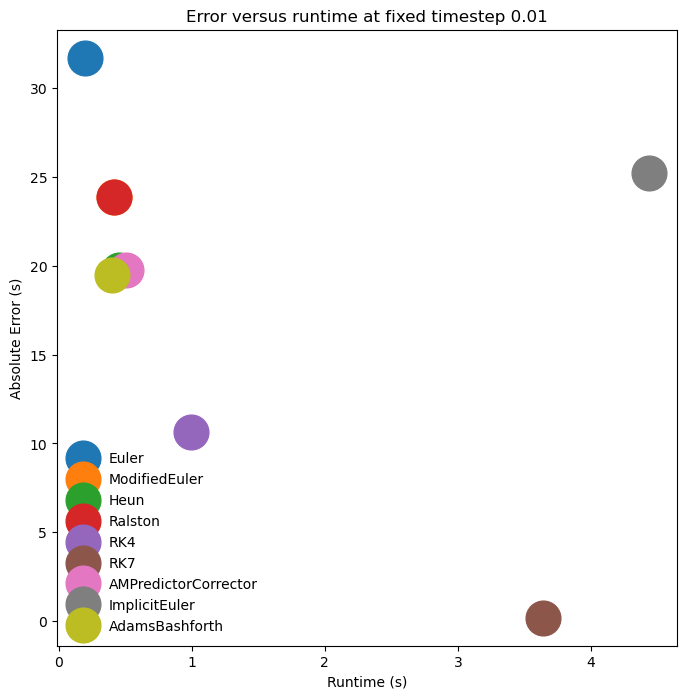

In [158]:
plt.figure(figsize=(8, 8))
for integrator_name in all_results.keys():
    plt.plot(
        all_results[integrator_name]["time"],
        all_results[integrator_name]["error"],
        ".",
        label=integrator_name,
        markersize=50
    )
plt.xlabel("Runtime (s)")
plt.ylabel("Absolute Error (s)")
plt.title(f"Error versus runtime at fixed timestep {dt_val}")
plt.legend(framealpha=0.0)

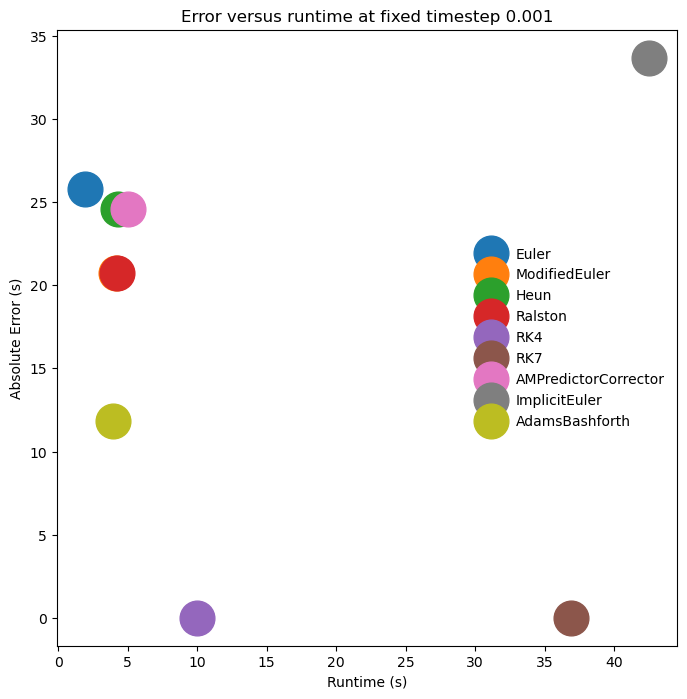

In [152]:
plt.figure(figsize=(8, 8))
for integrator_name in all_results.keys():
    plt.plot(
        all_results[integrator_name]["time"],
        all_results[integrator_name]["error"],
        ".",
        label=integrator_name,
        markersize=50
    )
plt.xlabel("Runtime (s)")
plt.ylabel("Absolute Error (s)")
plt.title(f"Error versus runtime at fixed timestep {dt_val}")
plt.legend(framealpha=0.0)